In [143]:
import json
import os
import random
from itertools import chain
from os.path import join, splitext
from pathlib import Path

import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from utils import map_data_frame_from_json, map_data_frame_to_json

In [ ]:
DATASET_FOLDER_PATH = Path('../2_playing_cards')

In [144]:
df = pd.read_csv(DATASET_FOLDER_PATH / '1_original_statistics.csv')
df = map_data_frame_from_json(df, column_list=['bbox'])
df.head()

,filename,width,height,size,name,bbox,area,area_p
0,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,9C,"[175, 367, 221, 399]",1472,0.003594
1,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,2D,"[190, 330, 235, 366]",1620,0.003955
2,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,8C,"[219, 290, 262, 330]",1720,0.004199
3,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,8C,"[405, 293, 447, 334]",1722,0.004204
4,000056694_jpg.rf.d3044032743b059a02077deb4bbf4...,640,640,409600,9C,"[426, 276, 470, 304]",1232,0.003008


In [145]:
# df = df[df.name == 'traffic light']
len(df)

96909

In [146]:
df_groupped = df.groupby(by='filename')

In [147]:
def get_intersection(bbox1, bbox2):
    x0, y0, x1, y1 = bbox1
    x2, y2, x3, y3 = bbox2
    x5, y5 = max(x0, x2), max(y0, y2)
    x6, y6 = min(x1, x3), min(y1, y3)

    if x5 >= x6 or y5 >= y6:
        return None

    return x5, y5, x6, y6


def get_sample_boxes(image_df, box_area=(0.2, 0.4), padding=0.1, max_attempts_count=100):
    """For each row:
    1. Calculate target area (so bbox area will be inside box_area interval)
    2. Ensure padding outside the bbox
    3. Randomly generate crop based on target area and ensure: bbox is inside the crop but no other bboxes intersect with it
    """
    result_list = []
    for idx, row in image_df.iterrows():
        image_width, image_height = row.width, row.height
        item_bbox = row.bbox
        x0, y0, x1, y1 = item_bbox
        width = x1 - x0
        height = y1 - y0
        area = width * height
        target_area = area / random.uniform(box_area[0], box_area[1])
        target_side = np.sqrt(target_area)
        sample_padding = int(target_side * padding)
        target_side = max(target_side, max(width, height) + sample_padding)  # bug, should be: 2 * sample_padding
        target_side = int(target_side)

        sample_x0 = x1 - target_side
        sample_y0 = y1 - target_side
        sample_x1 = x0
        sample_y1 = y0
        sample_x0 = max(sample_x0, 0)
        sample_y0 = max(sample_y0, 0)
        sample_x1 = min(sample_x1, image_width - target_side)
        sample_y1 = min(sample_y1, image_height - target_side)
        sample_x0, sample_y0 = sample_x0 + sample_padding, sample_y0 + sample_padding
        sample_x1, sample_y1 = sample_x1 - sample_padding, sample_y1 - sample_padding
        if sample_x0 >= sample_x1 or sample_y0 >= sample_y1:
            continue

        bbox_max = (sample_x0, sample_y0, sample_x1 + target_side, sample_y1 + target_side)
        bbox_invariant = x0 - padding, y0 - padding, x1 + padding, y1 + padding
        skip = False
        bbox_to_avoid_list = []
        for idx_inner, row_inner in image_df.iterrows():
            if idx_inner == idx or row_inner.name not in {'2H', '2S'}:
                continue
            check_bbox = row_inner.bbox

            intersection_max = get_intersection(bbox_max, check_bbox)
            if intersection_max is None:
                continue
            bbox_to_avoid_list.append(intersection_max)

            intersection_invariant = get_intersection(bbox_invariant, check_bbox)
            if intersection_invariant is not None:
                skip = True
                break

        if skip:
            continue

        result_bbox = None
        for _ in range(max_attempts_count):
            candidate_x0, candidate_y0 = random.uniform(sample_x0, sample_x1), \
                random.uniform(sample_y0, sample_y1)
            candidate_x1, candidate_y1 = candidate_x0 + target_side, candidate_y0 + target_side
            candidate_bbox = int(candidate_x0), int(candidate_y0), int(candidate_x1), int(candidate_y1)
            if any([get_intersection(candidate_bbox, avoid_bbox) is not None
                    for avoid_bbox in bbox_to_avoid_list]):
                continue

            result_bbox = candidate_bbox

        if result_bbox is None:
            continue

        result_list.append((idx, result_bbox))

    return result_list

In [148]:
random.seed(42)
data_list = []
for filename, df_group in tqdm(list(df_groupped)[:]):
    sample_box_list = get_sample_boxes(df_group)
    sample_df = pd.DataFrame(sample_box_list, columns=['id', 'sample_bbox']).set_index('id')
    sample_df = pd.merge(df_group, sample_df,
                         how='inner', left_index=True, right_index=True)
    data_list.append(sample_df)

  0%|          | 0/24233 [00:00<?, ?it/s]

In [149]:
df_samples = pd.concat(data_list, axis=0, ignore_index=True)
df_samples.rename({'bbox': 'object_bbox'}, axis='columns', inplace=True)
print(len(df_samples))
df_samples.head()

86543


,filename,width,height,size,name,object_bbox,area,area_p,sample_bbox
0,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,9C,"[175, 367, 221, 399]",1472,0.003594,"(167, 360, 234, 427)"
1,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,2D,"[190, 330, 235, 366]",1620,0.003955,"(180, 311, 244, 375)"
2,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,8C,"[219, 290, 262, 330]",1720,0.004199,"(206, 271, 282, 347)"
3,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,8C,"[405, 293, 447, 334]",1722,0.004204,"(392, 286, 461, 355)"
4,000056694_jpg.rf.d3044032743b059a02077deb4bbf4...,640,640,409600,9C,"[426, 276, 470, 304]",1232,0.003008,"(419, 254, 483, 318)"


In [150]:
df_out = df_samples.copy()
df_out = map_data_frame_to_json(df_out, column_list=['sample_bbox', 'object_bbox'])
df_out.to_csv(DATASET_FOLDER_PATH / '2_samples.csv', index=False)

# Split to train/val/test

In [151]:
df_samples = pd.read_csv('../2_playing_cards/2_samples.csv')
df_samples = map_data_frame_from_json(df_samples, column_list=['sample_bbox', 'object_bbox'])
print(len(df_samples))
df_samples.head()

86543


,filename,width,height,size,name,object_bbox,area,area_p,sample_bbox
0,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,9C,"[175, 367, 221, 399]",1472,0.003594,"[167, 360, 234, 427]"
1,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,2D,"[190, 330, 235, 366]",1620,0.003955,"[180, 311, 244, 375]"
2,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,8C,"[219, 290, 262, 330]",1720,0.004199,"[206, 271, 282, 347]"
3,000056694_jpg.rf.132f49ccfd4cc9e72ad7ceb43d845...,640,640,409600,8C,"[405, 293, 447, 334]",1722,0.004204,"[392, 286, 461, 355]"
4,000056694_jpg.rf.d3044032743b059a02077deb4bbf4...,640,640,409600,9C,"[426, 276, 470, 304]",1232,0.003008,"[419, 254, 483, 318]"


In [ ]:
# for bdd100k
df_samples = df_samples[(df_samples.timeofday != 'night')
                        & (df_samples.occluded == False)
                        & (df_samples.truncated == False)
                        & ((df_samples.trafic_light_color == 'G') | (pd.isna(df_samples.trafic_light_color)))]
len(df_samples)

In [152]:
# for cards
df_samples = df_samples[df_samples.name.map(lambda it: it in {'2H', '2S'})]
len(df_samples)

3274

## Sample data

774 4422


<Axes: ylabel='Density'>

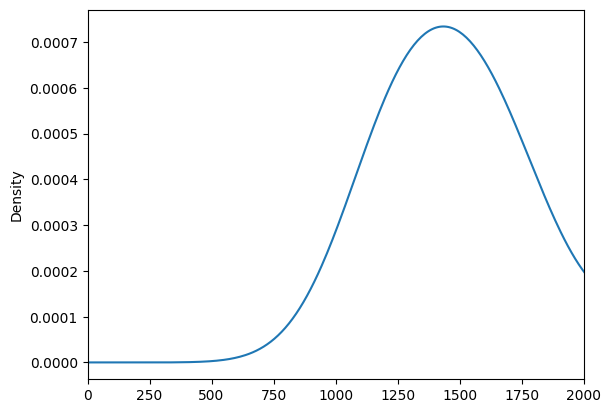

In [97]:
print(df_samples.area.min(), df_samples.area.max())
df_samples.area.plot(kind='density', xlim=(0, 2000))

In [153]:
class_count = df_samples['name'].nunique()
min_class_size = df_samples.name.value_counts().min()
class_indexes = list(chain(*[[i] * min_class_size for i in range(class_count)]))
target_indexes_list = train_test_split(class_indexes,
                                       train_size=2000,
                                       random_state=42,
                                       stratify=class_indexes,
                                       shuffle=True)[0]

class_count_list = [0] * class_count
for idx in target_indexes_list:
    class_count_list[idx] += 1
class_name_list = df_samples['name'].unique()
class_name_count_series = pd.Series(class_count_list, index=class_name_list)

# target_object_area = 600  # helmets
target_object_area = 1400  # playing cards


# target_object_area = 1200  # traffic lights
def sample_class_group(df_class):
    sample_size = class_name_count_series.loc[df_class.name]
    df_class['diff'] = df_class['area'].map(lambda area: abs(area - target_object_area))
    df_class.sort_values(by='diff', ascending=True, inplace=True, ignore_index=True)
    df_class.drop(columns=['diff'], inplace=True)

    return df_class.iloc[:sample_size]


df_filtered = df_samples.groupby(by='name')[df_samples.columns].apply(sample_class_group)
df_filtered.index = df_filtered.index.droplevel(0)
print(len(df_filtered))
df_filtered.head()

2000


,filename,width,height,size,name,object_bbox,area,area_p,sample_bbox
0,964216906_jpg.rf.beffbd241557e81b0ea2ae97f19ae...,640,640,409600,2H,"[347, 379, 382, 419]",1400,0.003418,"[323, 368, 393, 438]"
1,233904850_jpg.rf.806491878fb7896bc249529c5bbb4...,640,640,409600,2H,"[342, 470, 377, 510]",1400,0.003418,"[328, 448, 400, 520]"
2,741011575_jpg.rf.4d828ecdfa43fa94d67a4ae9c4eb5...,640,640,409600,2H,"[207, 201, 242, 241]",1400,0.003418,"[177, 189, 254, 266]"
3,427328716_jpg.rf.6700370a4e0a7fce2d360e41c99c2...,640,640,409600,2H,"[206, 243, 246, 278]",1400,0.003418,"[191, 221, 258, 288]"
4,673667265_jpg.rf.ad3b8e56119c3c6e460eb42161be2...,640,640,409600,2H,"[338, 232, 366, 282]",1400,0.003418,"[324, 214, 405, 295]"


In [154]:
class_counts = df_filtered.name.value_counts()
print(f'class_counts min: {class_counts.min()}\n'
      f'class_counts max: {class_counts.max()}\n'
      f'area min: {df_filtered["area"].min()}\n'
      f'area max: {df_filtered["area"].max()}\n'
      f'area diff: {df_filtered["area"].max() - df_filtered["area"].min()}')

class_counts min: 1000
class_counts max: 1000
area min: 774
area max: 2310
area diff: 1536


# Generate descriptors

In [155]:
df_train, df_val = train_test_split(df_filtered,
                                    train_size=1000,
                                    random_state=42,
                                    shuffle=True)
df_val, df_test = train_test_split(df_val,
                                   train_size=500,
                                   random_state=42,
                                   shuffle=True)
len(df_train), len(df_val), len(df_test)

(1000, 500, 500)

In [156]:
def save_df(df_to_save, path):
    df_out = df_to_save.copy()
    df_out = map_data_frame_to_json(df_out, column_list=['sample_bbox', 'object_bbox'])
    df_out.to_csv(path, index=True)

In [157]:
save_df(df_train, '../2_playing_cards/train.csv')
save_df(df_val, '../2_playing_cards/val.csv')
save_df(df_test, '../2_playing_cards/test.csv')

# Generate to YOLOv8 format data

In [160]:
def generate_yolov8(descriptor_path,
                    image_folder_path,
                    output_folder_path,
                    sample=1.0,
                    random_state=42,
                    draw_bbox=False,
                    precision=6):
    df_descriptor = pd.read_csv(descriptor_path, index_col=0)
    df_descriptor = map_data_frame_from_json(df_descriptor, column_list=['object_bbox', 'sample_bbox'])
    df_descriptor = df_descriptor.sample(frac=sample, random_state=random_state, ignore_index=False)
    print(f'Generating descriptors for {len(df_descriptor)} samples...')
    output_image_folder_path = join(output_folder_path, 'images')
    output_label_folder_path = join(output_folder_path, 'labels')
    os.makedirs(output_image_folder_path, exist_ok=True)
    os.makedirs(output_label_folder_path, exist_ok=True)
    for idx, row in tqdm(df_descriptor.iterrows()):
        img_path = join(image_folder_path, row.filename)
        x0, y0, x1, y1 = row.sample_bbox
        img = cv.imread(img_path)
        roi = img[y0: y1, x0: x1]
        object_x0, object_y0, object_x1, object_y1 = row.object_bbox
        object_x0, object_x1 = object_x0 - x0, object_x1 - x0
        object_y0, object_y1 = object_y0 - y0, object_y1 - y0
        filename_base, ext = splitext(row.filename)
        with open(join(output_label_folder_path, f'{filename_base}_{str(idx)}.txt'), mode='w+') as f:
            x_center = (object_x0 + object_x1) / 2 / roi.shape[1]
            y_center = (object_y0 + object_y1) / 2 / roi.shape[0]
            width = (object_x1 - object_x0) / roi.shape[1]
            height = (object_y1 - object_y0) / roi.shape[0]
            x_center = round(x_center, precision)
            y_center = round(y_center, precision)
            width = round(width, precision)
            height = round(height, precision)
            f.writelines([f'0 {x_center} {y_center} {width} {height}'])

        if draw_bbox:
            cv.rectangle(roi, (object_x0, object_y0), (object_x1, object_y1), (0, 0, 255), 1)
        cv.imwrite(join(output_image_folder_path, f'{filename_base}_{str(idx)}{ext}'), roi)


In [169]:
generate_yolov8('../2_playing_cards/train.csv',
                '../2_playing_cards/images',
                '../2_playing_cards/dataset_yolo/train_0025',
                draw_bbox=False,
                sample=0.025)

Generating descriptors for 25 samples...


0it [00:00, ?it/s]

# Convert to COCO format

In [136]:
def generate_coco(descriptor_path,
                  image_folder_path,
                  output_folder_path,
                  annotation_name,
                  category_name,
                  draw_bbox=False,
                  sample=1.0,
                  random_state=42):
    df_descriptor = pd.read_csv(descriptor_path, index_col=0)
    df_descriptor = map_data_frame_from_json(df_descriptor, column_list=['object_bbox', 'sample_bbox'])
    df_descriptor = df_descriptor.sample(frac=sample, random_state=random_state, ignore_index=False)
    print(f'Generating descriptors for {len(df_descriptor)} samples...')
    output_image_folder_path = join(output_folder_path, 'images')
    annotation_file_path = join(output_folder_path, 'annotations', annotation_name)
    os.makedirs(output_image_folder_path, exist_ok=True)
    os.makedirs(os.path.dirname(annotation_file_path), exist_ok=True)
    image_descriptor_list = []
    annotation_list = []
    for sample_id, row in tqdm(df_descriptor.iterrows()):
        img_path = join(image_folder_path, row.filename)
        x0, y0, x1, y1 = row.sample_bbox
        img = cv.imread(img_path)
        roi = img[y0: y1, x0: x1]
        object_x0, object_y0, object_x1, object_y1 = row.object_bbox
        object_x0, object_x1 = object_x0 - x0, object_x1 - x0
        object_y0, object_y1 = object_y0 - y0, object_y1 - y0
        object_width = object_x1 - object_x0
        object_height = object_y1 - object_y0
        filename_base, ext = splitext(row.filename)

        image_sample_filename = f'{filename_base}_{str(sample_id)}{ext}'
        image_descriptor_list.append({
            "file_name": image_sample_filename,
            "height": roi.shape[0],
            "width": roi.shape[1],
            "id": sample_id,
        })
        annotation_list.append({
            "segmentation": [],
            "iscrowd": 0,
            "image_id": sample_id,
            "category_id": 1,
            "bbox": [object_x0, object_y0, object_width, object_height],
            "area": object_width * object_height,
            "id": sample_id,
        })

        if draw_bbox:
            cv.rectangle(roi, (object_x0, object_y0), (object_x1, object_y1), (0, 0, 255), 1)
        cv.imwrite(join(output_image_folder_path, image_sample_filename), roi)
    categories = [{
        "supercategory": category_name,
        "id": 1,
        "name": category_name
    }]
    with open(annotation_file_path, mode='w+') as f:
        json.dump({
            "categories": categories,
            "images": image_descriptor_list,
            "annotations": annotation_list
        }, f, indent=4)

In [142]:
generate_coco('../2_playing_cards/train.csv',
              '../2_playing_cards/images',
              '../2_playing_cards/dataset_coco/',
              'annotation_train_0025.json',
              'card',
              draw_bbox=False,
              sample=0.025)

Generating descriptors for 25 samples...


0it [00:00, ?it/s]